In [45]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [46]:
from pyscf import ao2mo, gto, mcscf, scf
from qiskit.circuit import Parameter
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit_aer import AerSimulator
from qiskit.synthesis import LieTrotter
from qiskit.circuit.library import PauliEvolutionGate
from qiskit.providers.fake_provider import Fake20QV1
from qiskit_aer.primitives import EstimatorV2
from sympy import Matrix

## Krylov Quantum Diagonalization for Quantum Chemistry problems

In this notebook we explore the validity of the modified Hadamard test circuit for the Krylov diagonalization algorithm for finding the ground-state energy of molecular Hamiltonians. We focus on the Lithium Hydride (LiH) molecule, a standard prototype for quantum chemistry problems. As we will see, the approach is sound in theory - however, the resulting circuit depths are extremely large with naive compilation, and more efficient case-by-case compilation of the Trotter evolution step will be required for implementation on near-term devices. Another concern is the conditioning of the Krylov subspace -- we find that the ground-state energy found is quite sensitive to the regularization of the Krylov subspace.

<b> Modified Hadamard test for Fermionic Hamiltonians under a Jordan-Wigner transformation.

For Chemistry Hamiltonians mapped to qubits under a Jordan-Wigner transformation, the Krylov algorithm can be applied with minimal modification to the resulting qubit Hamiltonian. The reason for this is that the Jordan-Wigner transformation maps a fermionic creation / annihilation operator $c^\dagger$ / $c$ to a spin occupation creation / annihilation operator $S^+$, $S^-$. Therefore, we immediately know of an eigenstate of the qubit Hamiltonian, namely the fermionic vacuum, which under Jordan wigner is simply mapped to the $\ket{0}^{\otimes n}$ state. For other fermionic mappings such as Bravyi-Kitaev, the occupation information is delocalized in favour of localizing the parity information of the fermionic state under the fermion-qubit mapping. In this case, one can still work out what the resulting vacuum state of the qubit Hamiltonian will be, although it will not be as simple as $\ket{0}^{\otimes n}$ and may require complicated state preparation.

Note that we can efficiently compute the energy of the $\ket{0}^{\otimes n}$ state under a Pauli decomposed Hamiltonian. We can then correct the phase of the Krylov matrices $H^{krylov}$ and $S^{krylov}$ by multiplying the expectation values from the modified Hadamard matrix by the factor $exp(-iE0 *dt* n)$ for each Krylov dimension $n$.

## LiH molecule Krylov ground-state energy search 

Initialize the LiH molecule with pyscf with (courtesy: Meltem Tolunay's ADAPT-VQE notebook)

In [47]:
# LiH
distance = 1.59
mol = gto.Mole()
mol.build(
    verbose=0,
    atom=[["Li", (0, 0, 0)], ["H", (0, 0, distance)]],
    basis="sto-6g",
    spin=0,
    charge=0,
    symmetry="Coov",
)


rhf = scf.RHF(mol)
e_gs = rhf.kernel()
print('Mean-field energy estimate: ', e_gs)

Mean-field energy estimate:  -7.952130055344281


In [48]:
mf = scf.RHF(mol)
E1 = mf.kernel()
mx = mcscf.CASCI(mf, ncas=5, nelecas=(1, 1))
cas_space_symmetry = {"A1": 3, "E1x": 1, "E1y": 1}
mo = mcscf.sort_mo_by_irrep(mx, mf.mo_coeff, cas_space_symmetry)
E2 = mx.kernel(mo)[:2]

h1e, ecore = mx.get_h1eff()
h2e = ao2mo.restore(1, mx.get_h2eff(), mx.ncas)

<b> Map the Fermionic Hamiltonian to a Pauli decomposed qubit Hamiltonian

In [49]:
import numpy as np
from qiskit.quantum_info import SparsePauliOp


def cholesky(V, eps):
    no = V.shape[0]
    chmax, ng = 20 * no, 0
    W = V.reshape(no**2, no**2)
    L = np.zeros((no**2, chmax))
    Dmax = np.diagonal(W).copy()
    nu_max = np.argmax(Dmax)
    vmax = Dmax[nu_max]
    while vmax > eps:
        L[:, ng] = W[:, nu_max]
        if ng > 0:
            L[:, ng] -= np.dot(L[:, 0:ng], (L.T)[0:ng, nu_max])
        L[:, ng] /= np.sqrt(vmax)
        Dmax[: no**2] -= L[: no**2, ng] ** 2
        ng += 1
        nu_max = np.argmax(Dmax)
        vmax = Dmax[nu_max]
    L = L[:, :ng].reshape((no, no, ng))
    print(
        "accuracy of Cholesky decomposition ",
        np.abs(np.einsum("prg,qsg->prqs", L, L) - V).max(),
    )
    return L, ng


def identity(n):
    return SparsePauliOp.from_list([("I" * n, 1)])


def creators_destructors(n, mapping="jordan_wigner"):
    c_list = []
    if mapping == "jordan_wigner":
        for p in range(n):
            if p == 0:
                l, r = "I" * (n - 1), ""
            elif p == n - 1:
                l, r = "", "Z" * (n - 1)
            else:
                l, r = "I" * (n - p - 1), "Z" * p
            cp = SparsePauliOp.from_list([(l + "X" + r, 0.5), (l + "Y" + r, -0.5j)])
            c_list.append(cp)
    else:
        raise ValueError("Unsupported mapping.")
    d_list = [cp.adjoint() for cp in c_list]
    return c_list, d_list


def build_hamiltonian(ecore: float, h1e: np.ndarray, h2e: np.ndarray) -> SparsePauliOp:
    ncas, _ = h1e.shape

    C, D = creators_destructors(2 * ncas, mapping="jordan_wigner")
    Exc = []
    for p in range(ncas):
        Excp = [C[p] @ D[p] + C[ncas + p] @ D[ncas + p]]
        for r in range(p + 1, ncas):
            Excp.append(
                C[p] @ D[r] + C[ncas + p] @ D[ncas + r] + C[r] @ D[p] + C[ncas + r] @ D[ncas + p]
            )
        Exc.append(Excp)

    # low-rank decomposition of the Hamiltonian
    Lop, ng = cholesky(h2e, 1e-6)
    t1e = h1e - 0.5 * np.einsum("pxxr->pr", h2e)

    H = ecore * identity(2 * ncas)
    # one-body term
    for p in range(ncas):
        for r in range(p, ncas):
            H += t1e[p, r] * Exc[p][r - p]
    # two-body term
    for g in range(ng):
        Lg = 0 * identity(2 * ncas)
        for p in range(ncas):
            for r in range(p, ncas):
                Lg += Lop[p, r, g] * Exc[p][r - p]
        H += 0.5 * Lg @ Lg

    return H.chop().simplify()

In [50]:
H = build_hamiltonian(ecore, h1e, h2e)
print(f"The Hamiltonian consists of {len(H)} {2 * mx.ncas}-qubit Pauli operators.")

accuracy of Cholesky decomposition  1.1102230246251565e-16
The Hamiltonian consists of 276 10-qubit Pauli operators.


Check Hermiticity

In [51]:
np.isclose(H.to_matrix(), H.to_matrix().conj().T).all()

True

<b> Compute the eigenvalue E0 of the all zero state. Compare to exact diagonalization to verify accuracy.

In [52]:
#efficiently compute eigenvalue of H in |0> state

E0 = 0
for i,pauli in enumerate(H.paulis):
    if 'X' in [*pauli.to_label()] or 'Y' in [*pauli.to_label()]:
        continue
    else:
        E0 += H.coeffs[i]
E0

(-6.887881382038017+0j)

In [53]:
zero_state = np.zeros(1024)
zero_state[0] = 1
H.to_matrix()@zero_state

array([-6.88788138+0.j,  0.        +0.j,  0.        +0.j, ...,
        0.        +0.j,  0.        +0.j,  0.        +0.j])

<b> We will use a Hartree Fock Ansatz as the initial state $\ket{\psi}_0$.

In [54]:
def hartree_fock_bitstring(num_spatial_orbitals: int, num_particles: tuple[int, int]) -> list[bool]:
    """Compute the bitstring representing the Hartree-Fock state for the specified system.
    Args:
        num_spatial_orbitals: The number of spatial orbitals, has a min. value of 1.
        num_particles: The number of particles as a tuple storing the number of alpha- and beta-spin
                       electrons in the first and second number, respectively.
    Returns:
        The bitstring representing the state of the Hartree-Fock state as array of bools.
    Raises:
        ValueError: If the total number of particles is larger than the number of orbitals.
    """
    # validate the input
    assert num_spatial_orbitals >= 1
    num_alpha, num_beta = num_particles

    if any(n > num_spatial_orbitals for n in num_particles):
        raise ValueError("# of particles must be less than or equal to # of orbitals.")

    half_orbitals = num_spatial_orbitals
    bitstr = np.zeros(2 * num_spatial_orbitals, bool)
    bitstr[:num_alpha] = True
    bitstr[half_orbitals : (half_orbitals + num_beta)] = True

    return bitstr.tolist()

<b> Initialize Krylov parameters</b>: We will choose the 'optimal' dt expected from theory: $dt = \pi/||H||$

In [55]:
#KRYLOV PARAMETERS
subspace_dim = 100

#Technically, this is cheating - this is the provably optimal choice for dt
u,s,vh = np.linalg.svd(H.to_matrix())
dt = np.pi/max(s)
trotter_order = 2
dt

0.39406947078343263

In [56]:
num_spatial_orbitals = mx.ncas
num_particles = mx.nelecas

H_first_row = np.zeros(subspace_dim, dtype=np.complex128)
S_first_row = np.zeros(subspace_dim, dtype=np.complex128)

n_qubits = 2 * mx.ncas
backend = AerSimulator()

<b> Create the modified Hadamard Krylov circuit in qiskit

In [57]:
# Create hadamard test circuit for real part
hf_bitstring = hartree_fock_bitstring(num_spatial_orbitals, num_particles)

t = Parameter('t')
qr_evol = QuantumRegister(n_qubits)
qc_evol = QuantumCircuit(qr_evol)
qc_evol.compose(PauliEvolutionGate(H, time=t, synthesis=LieTrotter(reps=trotter_order)), list(range(n_qubits)), inplace=True)

qr = QuantumRegister(n_qubits+1)
qc = QuantumCircuit(qr)
qc.h(0)    
for i, hf_bit in enumerate(hf_bitstring):
    if hf_bit:
        qc.cx(0, i+1)
#qc.compose(controlled_state_prep, list(range(n_qubits+1)), inplace=True)
qc.compose(qc_evol,list(range(1,n_qubits+1)), inplace=True)
#qc.compose(controlled_state_prep_inv, list(range(n_qubits+1)), inplace=True)
for i, hf_bit in enumerate(hf_bitstring):
    if hf_bit:
        qc.cx(0, i+1, ctrl_state='0')
#krylov_circ = qc.decompose().copy()
krylov_circ = transpile(qc, backend)
print('The optimized circuit has 2Q gates depth: ', krylov_circ.depth(lambda x: x[0].num_qubits ==2))

The optimized circuit has 2Q gates depth:  3184


That is a lot of gates! This is an important problem that will be important to work around for fermionic simulation and quantum chemistry using various heuristics. Highly non-local qubit Hamiltonians can result from fermion-qubit mappings of electronic-structure Hamiltonians. The trotterized time-evolution for the Kyrlov subspace algorithm requires many swaps to compile to a local gate-set.
A first step could be to try different fermion-qubit mappings. 
For this demo, we will use the Aer Simulator.

<b> Run estimator for real and imaginary parts of $H^{krylov}$ and $S^{krylov}$:

In [58]:
estimator = EstimatorV2()
shots = 10000000

# Define a set of observables to measure
observables_S_real = ['I'*(n_qubits) + 'X']#['X'+'I'*(n_qubits)]#['I'*(n_qubits) + 'X']
observables_S_imag = ['I'*(n_qubits) + 'Y']#['Y'+'I'*(n_qubits)]#['I'*(n_qubits) + 'Y']
observables_H_real = []
observables_H_imag = []

for pauli, coeff in zip(H.paulis, H.coeffs):
    observable = pauli[::-1].to_label() 
    observables_H_real.append([observable+'X'])
    observables_H_imag.append([observable+'Y'])
    #observables_H_real.append(['X'+pauli.to_label()])
    #observables_H_imag.append(['Y'+pauli.to_label()])

# Define a sweep over parameter values
parameters = []
for idx_ket in range(subspace_dim):
        parameters.append(dt*idx_ket)
params = np.vstack(parameters).T

pub = (krylov_circ, observables_S_real, params)
job = estimator.run([pub], precision=1/np.sqrt(shots))
S_real_results = job.result()[0]

pub = (krylov_circ, observables_S_imag, params)
job = estimator.run([pub], precision=1/np.sqrt(shots))
S_imag_results = job.result()[0]

pub = (krylov_circ, observables_H_real, params)
job = estimator.run([pub], precision=1/np.sqrt(shots))
H_real_results = job.result()[0]

pub = (krylov_circ, observables_H_imag, params)
job = estimator.run([pub], precision=1/np.sqrt(shots))
H_imag_results = job.result()[0]

In [59]:
S_first_row = np.zeros(subspace_dim, dtype=complex) 
for idx_ket in range(subspace_dim):
        # Get expectation values from experiment
        expval_real = S_real_results.data.evs[0][idx_ket]
        expval_imag = S_imag_results.data.evs[0][idx_ket]

        # Get expectation values
        expval = (expval_real + 1j*expval_imag)*np.exp(1j*E0*dt*idx_ket)

        # Fill-in matrix elements
        S_first_row[idx_ket] = expval

H_first_row = np.zeros(subspace_dim, dtype=complex)
for idx_ket in range(subspace_dim):
    for obs_idx, (pauli, coeff) in enumerate(zip(H.paulis, H.coeffs)):
        # Get expectation values from experiment
        expval_real = H_real_results.data.evs[obs_idx][idx_ket]
        expval_imag = H_imag_results.data.evs[obs_idx][idx_ket]
        

        # # Get expectation values
        expval = (expval_real + 1j*expval_imag)*np.exp(1j*E0*dt*idx_ket)


        # Fill-in matrix elements
        H_first_row[idx_ket] += coeff*expval

<b> Solve the resulting generalized eigenvalue problem

In [60]:
from scipy.linalg import toeplitz
from krylov_trotter_circuits import  solve_regularized_gen_eig
from copy import deepcopy
H_krylov = toeplitz(H_first_row.conj())
S_krylov = toeplitz(S_first_row.conj())
thresholds = np.linspace(0.001, 0.01, 15)
circuit_energies = []
for ii, i in enumerate(range(1,subspace_dim)):
    gs_energy = solve_regularized_gen_eig(H_krylov[:i,:i], S_krylov[:i,:i], k=1, threshold=0.03)
    circuit_energies.append(gs_energy)
    if ii%10 == 0:
        print(gs_energy)

[-6.9019159]
[-7.01709882]
[-6.90462859]
[-7.2506824]
[-8.67117546]
[-10.12954471]
[-9.97052418]
[-9.57060551]
[-9.8642946]
[-9.71384989]


In [29]:
print(circuit_energies[-1])

[-9.97616248]


 Notice that the resulting Krylov subspace has lost variationality - the resulting ground-state energy is lower than the true energy. This is an indication that the regularization threshold is too low. Of course, this is impossible to know without knowing the true ground state energy beforehand (as we do here). Let us re-run the above cells with a higher threshold.

In [ ]:
from scipy.linalg import toeplitz
from krylov_trotter_circuits import  solve_regularized_gen_eig
from copy import deepcopy
H_krylov = toeplitz(H_first_row.conj())
S_krylov = toeplitz(S_first_row.conj())
thresholds = np.linspace(0.001, 0.01, 15)
circuit_energies = []
for ii, i in enumerate(range(5,subspace_dim)):
    gs_energy = solve_regularized_gen_eig(H_krylov[:i,:i], S_krylov[:i,:i], k=1, threshold=0.3)
    circuit_energies.append(gs_energy)
    if ii%10 == 0:
        print(gs_energy)
print(circuit_energies[-1])

<b> Comparisons to exact state-vector simulations </b>

In the following cells, we will run the Krylov diagonalization algorithms with state-vector methods and compare with the above circuit simulation. We first run the exact Krylov algorithm by using trotterized time evolution, and evaluating the Krylov subspace matrix elements directly. This gives us a point of comparison for when Trotter error is the only source of non-algorithmic error. 

In [31]:
H_op = build_hamiltonian(ecore, h1e, h2e)
from qiskit.quantum_info import Operator
import scipy as sp
t = Parameter('t')
qr_evol = QuantumRegister(n_qubits)
qc_evol = QuantumCircuit(qr_evol)
qc_evol.compose(PauliEvolutionGate(H_op, time=t, synthesis=LieTrotter(reps=trotter_order)), list(range(n_qubits)), inplace=True)
trotter_op = Operator(qc_evol.assign_parameters({t: dt})).to_matrix()

# Make it sparse and calculate true GS
H_mat = H_op.to_matrix(sparse=True)
true_gse, true_gs = sp.sparse.linalg.eigsh(H_mat, which='SA', k=1)
true_gse = true_gse[0]

d = subspace_dim # Krylov dimension

num_spatial_orbitals = mx.ncas
num_particles = mx.nelecas
hartree_bitstring = hartree_fock_bitstring(num_spatial_orbitals, num_particles)

accuracy of Cholesky decomposition  1.1102230246251565e-16


In [32]:
#exact

import numpy as np
import scipy as sp
from scipy.sparse import kron as spkron
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

def tensor(op_list):
    op = op_list[0]
    for i in range(1, len(op_list)):
        op = spkron(op, op_list[i], format='csr')
    return op

H_op = build_hamiltonian(ecore, h1e, h2e)

zero, one = np.array([1,0]), np.array([0,1])
X,Y,Z,I= np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]]), np.eye(2)
H = np.sqrt(1/2)*np.array([[1,1],[1,-1]])

# Make it sparse and calculate true GS
H_mat = H_op.to_matrix(sparse=True)
true_gse, true_gs = sp.sparse.linalg.eigsh(H_mat, which='SA', k=1)
true_gse = true_gse[0]

num_spatial_orbitals = mx.ncas
num_particles = mx.nelecas
hartree_bitstring = hartree_fock_bitstring(num_spatial_orbitals, num_particles)
zero, one = np.array([1,0]), np.array([0,1])
v0 = tensor([one if hartree_bitstring[i] else zero for i in range(len(hartree_bitstring))])
v0 = v0.T
# Construct Krylov vectors
v = [v0.toarray()]
for i in range(d-1):
    #ui = sp.sparse.linalg.expm_multiply(-1j*H_mat*dt, v[i])
    ui = trotter_op@v[i]
    ui = ui/np.linalg.norm(ui)
    v.append(ui)

v = np.array(v).T

# Construct Krylov matrices
H_kry = np.conj(v[0]).T @ H_mat @ v[0]
S_kry = np.conj(v[0]).T @ v[0]


gnd_en_kry_est_list = []
for d in range(1, d+1):
    # Solve generalized eigenvalue problem
    gnd_en_kry_est = solve_regularized_gen_eig(H_kry[:d, :d], S_kry[:d, :d], threshold=0.003)
    gnd_en_kry_est_list.append(gnd_en_kry_est)
    if d % 10 == 0:
        print('The estimated ground state energy is: ', gnd_en_kry_est)

accuracy of Cholesky decomposition  1.1102230246251565e-16
The estimated ground state energy is:  [-7.95359642]
The estimated ground state energy is:  [-7.94717095]
The estimated ground state energy is:  [-7.95786203]
The estimated ground state energy is:  [-7.96979123]
The estimated ground state energy is:  [-7.97163509]
The estimated ground state energy is:  [-7.97143456]
The estimated ground state energy is:  [-7.97168608]
The estimated ground state energy is:  [-7.97147199]
The estimated ground state energy is:  [-7.97183722]
The estimated ground state energy is:  [-7.97178602]


Notice that the ideal algorithm works quite well, and converges close to the true ground state energy quickly with the Krylov subspace dimension.

<b> Statevector modified Hadamard test: </b> Next, we compare to state-vector simulation of the modified Hadamard test circuit. This gives us a point of comparison to when there is commutation error from the Trotter evolution, but no shot noise.

In [33]:
#exact

import numpy as np
import scipy as sp
from scipy.sparse import kron as spkron
from scipy.sparse.linalg import matrix_power
import networkx as nx
import matplotlib.pyplot as plt
from qiskit.quantum_info import SparsePauliOp

def tensor(op_list):
    op = op_list[0]
    for i in range(1, len(op_list)):
        op = spkron(op, op_list[i], format='csr')
    return op

H_op = build_hamiltonian(ecore, h1e, h2e)

zero, one = np.array([1,0]), np.array([0,1])
X,Y,Z,I= np.array([[0,1],[1,0]]), np.array([[0,-1j],[1j,0]]), np.array([[1,0],[0,-1]]), np.eye(2)
op_dict = {'X':X, 'Y':Y, 'Z':Z, 'I':I}

Hadmarad = np.sqrt(1/2)*np.array([[1,1],[1,-1]])

all_zero = tensor([zero for _ in range(11)])
all_zero = tensor([Hadmarad]+[I for _ in range(10)])@all_zero.T
control_prep = tensor([np.outer(zero, zero)]+[I for _ in range(10)]) + tensor([np.outer(one, one)]+[X if hartree_bitstring[i] else I for i in range(10)]) 
control_prep_inv = tensor([np.outer(one, one)]+[I for _ in range(10)]) + tensor([np.outer(zero, zero)]+[X if hartree_bitstring[i] else I for i in range(10)]) 


pauli_list_S_real = [tensor([X]+[I for _ in range(10)])]
pauli_list_S_imag = [tensor([Y]+[I for _ in range(10)])]
pauli_list_H_real = [tensor([X]+[op_dict[H_op.to_list()[i][0][j]] for j in range(10)]) for i in range(len(H_op.to_list()))]
pauli_list_H_imag = [tensor([Y]+[op_dict[H_op.to_list()[i][0][j]] for j in range(10)]) for i in range(len(H_op.to_list()))]

H_real = np.zeros(d, dtype=np.complex128)
H_imag = np.zeros(d, dtype=np.complex128)
S_real = np.zeros(d, dtype=np.complex128)
S_imag = np.zeros(d, dtype=np.complex128)
for i, p in enumerate(pauli_list_S_real):
    for n in range(d):
        v0 = control_prep@all_zero
        v0 = tensor([I, matrix_power(trotter_op, n)])@v0
        v0 = control_prep_inv@v0
        S_real[n]+= np.real((v0.conj().T@p@v0).toarray()[0][0])*np.exp(1j*E0*n*dt)
for i, p in enumerate(pauli_list_S_imag):
    for n in range(d):
        v0 = control_prep@all_zero
        v0 = tensor([I, matrix_power(trotter_op, n)])@v0
        v0 = control_prep_inv@v0
        S_imag[n] += np.real((v0.conj().T@p@v0).toarray()[0][0])*np.exp(1j*E0*n*dt)
print('done')
for i in range(len(pauli_list_H_real)):
    if i%20 == 0:
        print(i)
    for n in range(d):
        v0 = control_prep@all_zero
        v0 = tensor([I, matrix_power(trotter_op, n)])@v0
        v0 = control_prep_inv@v0
        H_real[n] += H_op.to_list()[i][1]*np.real((v0.conj().T@pauli_list_H_real[i]@v0).toarray()[0][0])*np.exp(1j*E0*n*dt)
        H_imag[n] += H_op.to_list()[i][1]*np.real((v0.conj().T@pauli_list_H_imag[i]@v0).toarray()[0][0])*np.exp(1j*E0*n*dt)



accuracy of Cholesky decomposition  1.1102230246251565e-16
done
0
20
40
60
80
100
120
140
160
180
200
220
240
260


In [42]:
H_krylov_row1 = (H_real+1j*H_imag)
S_krylov_row1 = (S_real+1j*S_imag)
H_krylov = toeplitz(H_krylov_row1.conj())
S_krylov = toeplitz(S_krylov_row1.conj())

state_vector_gs_Es = []
for i in range(1,d):
    H_krylov = toeplitz(H_krylov_row1.conj())[:i,:i]
    S_krylov = toeplitz(S_krylov_row1.conj())[:i,:i]
    E = solve_regularized_gen_eig(H_krylov, S_krylov, threshold=0.3)
    if i%10 == 0:
        print(E)
    state_vector_gs_Es.append(E)

[-6.89686954]
[-7.86979782]
[-7.98582633]
[-7.91084362]
[-7.92378549]
[-7.91712444]
[-7.9116178]
[-7.91975255]
[-7.90484937]


<b> Final comparison and conclusions

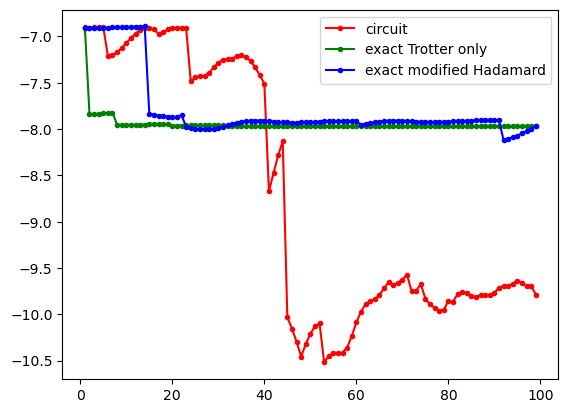

In [65]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(np.arange(1,subspace_dim), circuit_energies, 'r.-', label='circuit')
plt.plot(np.arange(1,subspace_dim), gnd_en_kry_est_list[1:], 'g.-', label='exact Trotter only')
plt.plot(np.arange(1,subspace_dim), state_vector_gs_Es, 'b.-', label='exact modified Hadamard')
plt.legend()
plt.show()

We suspect there is likely an issue with the qiskit estimator after extensive debugging. It is clear that the algorithm converges from the statevector simulations.